In [1]:
from ultralytics import YOLO

In [2]:
# Load a COCO-pretrained YOLOv5n model
model = YOLO('yolov5lu.pt')

In [3]:
mypreds=[]
myImg=None

In [4]:
import cv2
import numpy as np

class MyLetterBox:
    """Resize image and padding for detection, instance segmentation, pose."""

    def __init__(self, new_shape=(640, 640), auto=False, scaleFill=False, scaleup=True, center=True, stride=32):
        """Initialize LetterBox object with specific parameters."""
        self.new_shape = new_shape
        self.auto = auto
        self.scaleFill = scaleFill
        self.scaleup = scaleup
        self.stride = stride
        self.center = center  # Put the image in the middle or top-left

    def __call__(self, labels=None, image=None):
        """Return updated labels and image with added border."""
        if labels is None:
            labels = {}
        img = labels.get("img") if image is None else image
        shape = img.shape[:2]  # current shape [height, width]
        new_shape = labels.pop("rect_shape", self.new_shape)
        if isinstance(new_shape, int):
            new_shape = (new_shape, new_shape)

        # Scale ratio (new / old)
        r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
        if not self.scaleup:  # only scale down, do not scale up (for better val mAP)
            r = min(r, 1.0)

        # Compute padding
        ratio = r, r  # width, height ratios
        new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
        dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
        if self.auto:  # minimum rectangle
            dw, dh = np.mod(dw, self.stride), np.mod(dh, self.stride)  # wh padding
        elif self.scaleFill:  # stretch
            dw, dh = 0.0, 0.0
            new_unpad = (new_shape[1], new_shape[0])
            ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

        if self.center:
            dw /= 2  # divide padding into 2 sides
            dh /= 2

        if shape[::-1] != new_unpad:  # resize
            img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
        top, bottom = int(round(dh - 0.1)) if self.center else 0, int(round(dh + 0.1))
        left, right = int(round(dw - 0.1)) if self.center else 0, int(round(dw + 0.1))
        img = cv2.copyMakeBorder(
            img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(114, 114, 114)
        )  # add border
        if labels.get("ratio_pad"):
            labels["ratio_pad"] = (labels["ratio_pad"], (left, top))  # for evaluation

        if len(labels):
            labels = self._update_labels(labels, ratio, dw, dh)
            labels["img"] = img
            labels["resized_shape"] = new_shape
            return labels
        else:
            return img

In [5]:
from ultralytics.models.yolo.detect import DetectionPredictor
from ultralytics.engine.results import Results
from ultralytics.utils import ops

class MyDetectionPredictor(DetectionPredictor):

    def pre_transform(self, im):
        """
        Pre-transform input image before inference.
    
        Args:
            im (List(np.ndarray)): (N, 3, h, w) for tensor, [(h, w, 3) x N] for list.
    
        Returns:
            (list): A list of transformed images.
        """
        same_shapes = all(x.shape == im[0].shape for x in im)
        # auto = same_shapes and self.model.pt
        auto = False
        letterbox = MyLetterBox(self.imgsz, auto=auto, stride=self.model.stride)
        return [letterbox(image=x) for x in im]
    
    def preprocess(self, im):
        return super().preprocess(im)
        
    def inference(self, im, *args, **kwargs):
        """Runs inference on a given image using the specified model and arguments."""
        visualize = (
            increment_path(self.save_dir / Path(self.batch[0][0]).stem, mkdir=True)
            if self.args.visualize and (not self.source_type.tensor)
            else False
        )
        preds = self.model(im, augment=self.args.augment, visualize=visualize, embed=self.args.embed, *args, **kwargs)
        print(type(preds))
        mypreds.append(preds[0].clone().detach())
        for pred in preds[1]:
            mypreds.append(pred.clone().detach())
        return preds 
       
    def postprocess(self, preds, img, orig_imgs):
        """Post-processes predictions and returns a list of Results objects."""
        preds = ops.non_max_suppression(
            preds,
            self.args.conf,
            self.args.iou,
            agnostic=self.args.agnostic_nms,
            max_det=self.args.max_det,
            classes=self.args.classes,
        )

        if not isinstance(orig_imgs, list):  # input images are a torch.Tensor, not a list
            orig_imgs = ops.convert_torch2numpy_batch(orig_imgs)

        results = []
        for i, pred in enumerate(preds):
            orig_img = orig_imgs[i]
            pred[:, :4] = ops.scale_boxes(img.shape[2:], pred[:, :4], orig_img.shape)
            img_path = self.batch[0][i]
            results.append(Results(orig_img, path=img_path, names=self.model.names, boxes=pred))
        return results

In [6]:
custom = {"conf": 0.25, "save": False, "mode": "predict"}
args = {**model.overrides, **custom}
myDetectionPredictor=MyDetectionPredictor(overrides=args, _callbacks=model.callbacks)

In [7]:
results = model(source='https://ultralytics.com/images/bus.jpg', predictor=myDetectionPredictor)


Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
<class 'list'>
image 1/1 /workspace/bus.jpg: 640x640 4 persons, 1 bus, 30.2ms
Speed: 2.8ms preprocess, 30.2ms inference, 429.6ms postprocess per image at shape (1, 3, 640, 640)


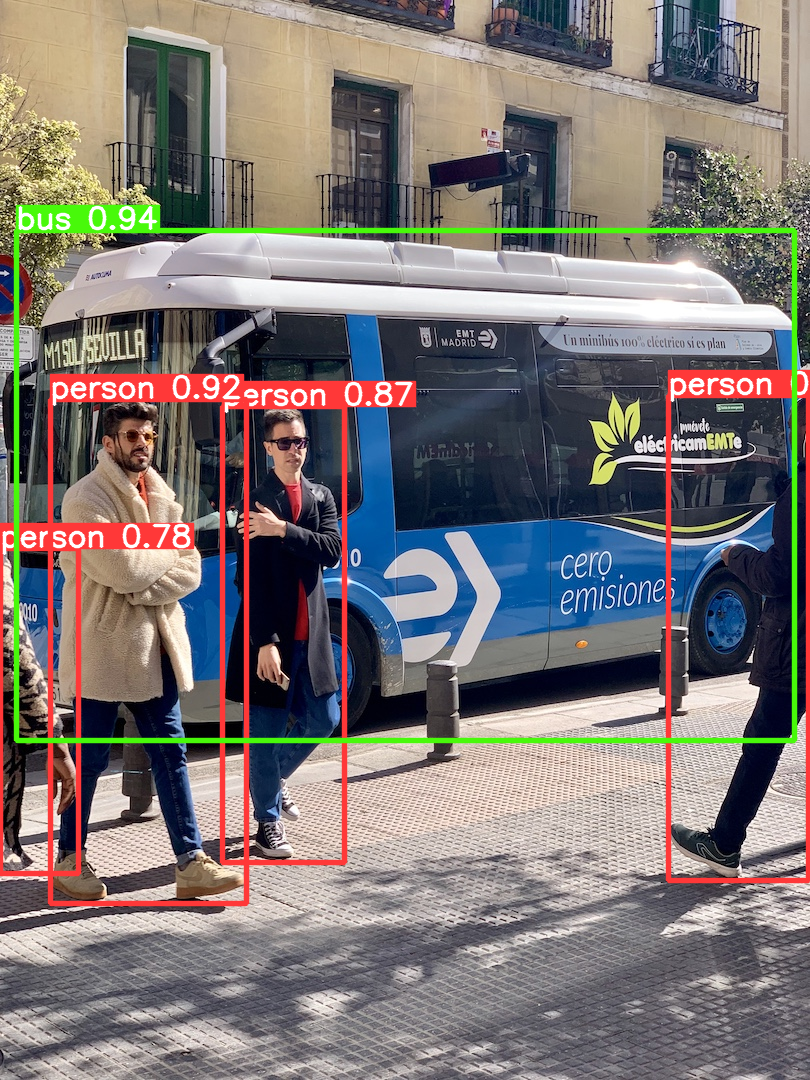

In [8]:
for result in results:
    result.show()

In [9]:
for pred in mypreds:
    print(pred.shape)

torch.Size([1, 84, 8400])
torch.Size([1, 144, 80, 80])
torch.Size([1, 144, 40, 40])
torch.Size([1, 144, 20, 20])
